<a href="https://colab.research.google.com/github/Jude704/MastersThesis/blob/main/Becnhmark_skin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Basic Packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

#Pyod
try:
  import pyod
except:
  !pip install pyod
finally:
  import pyod
  from pyod.models.iforest import IForest
  from pyod.models.ocsvm import OCSVM
  from pyod.models.lof import LOF
  from pyod.models.cblof import CBLOF
  from pyod.models.knn import KNN
  from pyod.utils.data import evaluate_print

#Isotree
try:
  import isotree
except: 
  !pip install isotree
finally:
  from isotree import IsolationForest

#Machine Learning - Sci-kit Learn

##Pre-processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing

##Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix

##Hyper Parameter Tuning
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.model_selection import GridSearchCV

#Umap
import umap

#Warnings
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

In [ ]:
#Functions 

def train_test_split(full_dataframe, train_size, test_size, random_state = 1):
    train_set = full_dataframe.sample(random_state = random_state, n = train_size)
    train_X = train_set.drop('original.label', axis = 1) 
    train_y = train_set['original.label']
    
    test_set = full_dataframe.drop(train_set.index).sample(random_state = random_state, n = test_size)
    test_X = test_set.drop('original.label', axis = 1)
    test_y = test_set['original.label']
    return train_X, test_X, train_y, test_y

def get_contamination_percentages(label_series, normal_value):
    return len(label_series[label_series != normal_value])/len(label_series)
    
def get_prediction(classifier, train_X, test_X, train_y, test_y, model_name =''):
  
    clf = classifier.fit(train_X)
    pred = clf.predict(test_X)

    #Evaluate using Pyod built-in function
    print("On Training Data:")
    evaluate_print(model_name, train_y, clf.decision_scores_) #raw outlier scores
    print("\nOn Test Data:")
    evaluate_print(model_name, test_y, clf.decision_function(test_X)) #decision_function(X_test): outlier scores for predicted test data
    
    print("\n", model_name, " Classification Report: \n" , classification_report(test_y, pred))
    #print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
    print("\n", model_name, "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
    print("\n", model_name, "f1-score", f1_score(test_y, pred))
    
    plt.figure()
    sns.heatmap(data = confusion_matrix(test_y, pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
    plt.title('Confusion Matrix', fontsize = 14)
    
    plt.figure()
    model_decision = clf.decision_function(test_X)
    fpr, tpr, threshold = roc_curve(test_y, model_decision)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def get_prediction_iso(classifier, train_X, test_X, train_y, test_y, model_name =''):

    clf = classifier.fit(train_X)
    pred = clf.predict(test_X)
    
    temp_pred = np.array(pred)
    temp_pred[temp_pred > 0.50] = 1
    temp_pred[temp_pred < 0.50] = 0

    print("\n", model_name, " Classification Report: \n" , classification_report(test_y, temp_pred))
    print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(test_y, temp_pred))
    print("\n", model_name, "Matthews Correlation Coefficient", matthews_corrcoef(test_y, temp_pred))
    print("\n", model_name, "f1-score", f1_score(test_y, temp_pred))
    plt.figure()
    sns.heatmap(data = confusion_matrix(test_y, temp_pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
    plt.title('Confusion Matrix', fontsize = 14)
    
    plt.figure()
    model_decision = clf.decision_function(test_X)
    fpr, tpr, threshold = roc_curve(test_y, model_decision)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


In [ ]:
skin_924 = pd.read_csv("skin_benchmark_0924.csv")
skin_941 = pd.read_csv("skin_benchmark_0941.csv")
skin_942 = pd.read_csv("skin_benchmark_0942.csv")

skin_924 = skin_924.drop(['point.id','origin', 'motherset', 'ground.truth', 'diff.score'],axis=1)
skin_941 = skin_941.drop(['point.id', 'origin', 'motherset', 'ground.truth', 'diff.score'],axis=1)
skin_942 = skin_942.drop(['point.id', 'origin', 'motherset', 'ground.truth', 'diff.score'],axis=1)

In [ ]:
skin_924['original.label'] = skin_924['original.label'].apply(lambda z: 0 if(z == 2) else 1)
skin_941['original.label'] = skin_941['original.label'].apply(lambda z: 0 if(z == 2) else 1)
skin_942['original.label'] = skin_942['original.label'].apply(lambda z: 0 if(z == 2) else 1)

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(skin_942, 4200, 1800, 42)

In [ ]:
#Oversampling with Adasyn
train_X_resampled, train_y_resampled= ADASYN(ratio = 'minority').fit_sample(train_X, train_y)

In [ ]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y, 0))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 0))

Percentage Training Set Contamination:  0.009523809523809525
Percentage Test Set Contamination:      0.011111111111111112


IForest

---



On Training Data:
IForest ROC:0.8718, precision @ rank n:0.0

On Test Data:
IForest ROC:0.8814, precision @ rank n:0.0

 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1780
           1       0.00      0.00      0.00        20

    accuracy                           0.98      1800
   macro avg       0.49      0.49      0.49      1800
weighted avg       0.98      0.98      0.98      1800


 IForest Matthews Correlation Coefficient -0.010653379535009885

 IForest f1-score 0.0


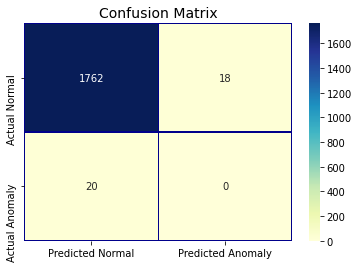

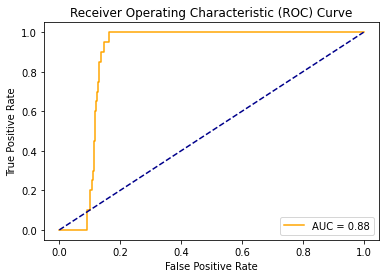

In [ ]:
get_prediction(IForest(n_estimators = 50, max_samples = 128, contamination = 0.01), 
               train_X, test_X, train_y, test_y, 'IForest')

OCSVM

---



On Training Data:
OCSVM ROC:0.8829, precision @ rank n:0.0

On Test Data:
OCSVM ROC:0.8898, precision @ rank n:0.0

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1780
           1       0.00      0.00      0.00        20

    accuracy                           0.98      1800
   macro avg       0.49      0.50      0.49      1800
weighted avg       0.98      0.98      0.98      1800


 OCSVM Matthews Correlation Coefficient -0.010038470867858362

 OCSVM f1-score 0.0


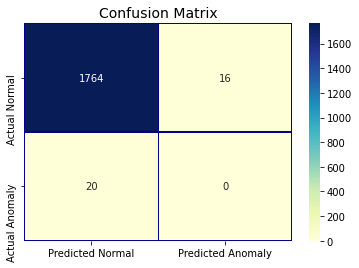

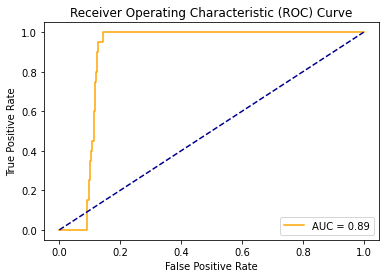

In [ ]:
get_prediction(OCSVM(gamma = 'scale', contamination= 0.01, kernel = 'rbf'),
               train_X, test_X, train_y, test_y, 'OCSVM')

LOF

---



On Training Data:
LOF ROC:0.371, precision @ rank n:0.4335

On Test Data:
LOF ROC:0.5989, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1780
           1       0.00      0.00      0.00        20

    accuracy                           0.97      1800
   macro avg       0.49      0.49      0.49      1800
weighted avg       0.98      0.97      0.98      1800


 LOF Matthews Correlation Coefficient -0.013564216563935593

 LOF f1-score 0.0


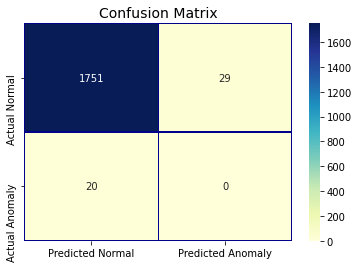

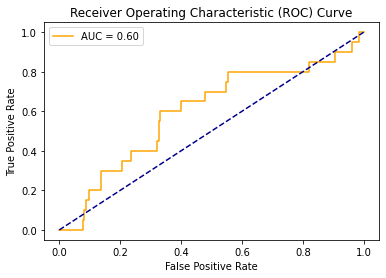

In [ ]:
get_prediction(LOF(n_neighbors=20, contamination= 0.01, algorithm='auto', metric = 'cosine'), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'LOF')

CBLOF

---



On Training Data:
CBLOF ROC:0.3524, precision @ rank n:0.409

On Test Data:
CBLOF ROC:0.6317, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1780
           1       0.00      0.00      0.00        20

    accuracy                           0.97      1800
   macro avg       0.49      0.49      0.49      1800
weighted avg       0.98      0.97      0.97      1800


 CBLOF Matthews Correlation Coefficient -0.01598006930251483

 CBLOF f1-score 0.0


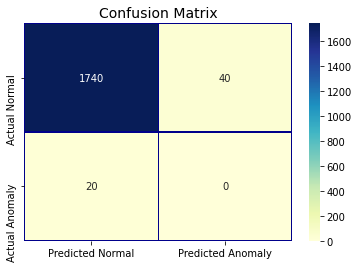

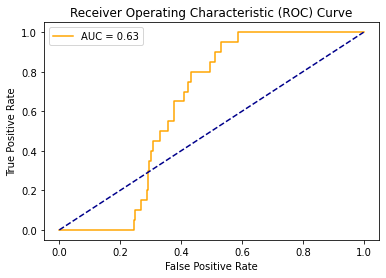

In [ ]:
get_prediction(CBLOF(contamination= 0.01, n_clusters= 25, alpha= 0.9, beta= 15, random_state=42), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'CBLOF')

KNN

---



On Training Data:
KNN ROC:0.278, precision @ rank n:0.2881

On Test Data:
KNN ROC:0.7699, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1780
           1       0.00      0.00      0.00        20

    accuracy                           0.97      1800
   macro avg       0.49      0.49      0.49      1800
weighted avg       0.98      0.97      0.97      1800


 KNN Matthews Correlation Coefficient -0.01598006930251483

 KNN f1-score 0.0


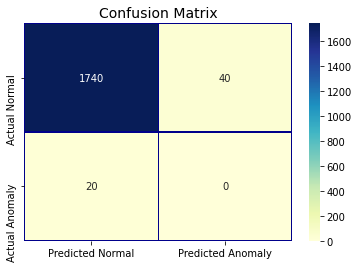

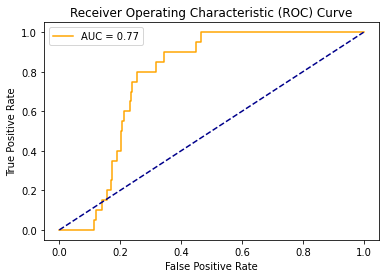

In [ ]:
get_prediction(KNN(n_neighbors= 20, method= 'median', algorithm='auto',contamination= 0.01), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'KNN')

IForest-Isotree

---




 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.74      0.85      1780
           1       0.04      1.00      0.08        20

    accuracy                           0.75      1800
   macro avg       0.52      0.87      0.47      1800
weighted avg       0.99      0.75      0.84      1800


 IForest  Confusion Matrix: 
 [[1325  455]
 [   0   20]]

 IForest Matthews Correlation Coefficient 0.17703785173285877

 IForest f1-score 0.08080808080808081


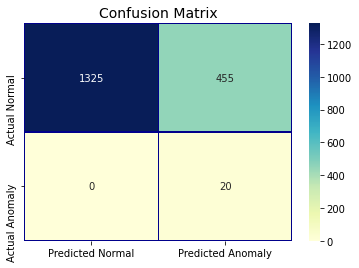

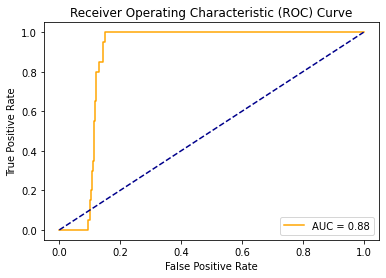

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 256, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'IForest')

SciForest-Isotree

---




 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.88      0.93      1780
           1       0.06      0.65      0.11        20

    accuracy                           0.88      1800
   macro avg       0.53      0.77      0.52      1800
weighted avg       0.99      0.88      0.93      1800


 SciForest  Confusion Matrix: 
 [[1568  212]
 [   7   13]]

 SciForest Matthews Correlation Coefficient 0.1682694468451508

 SciForest f1-score 0.10612244897959183


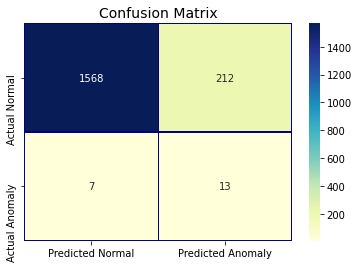

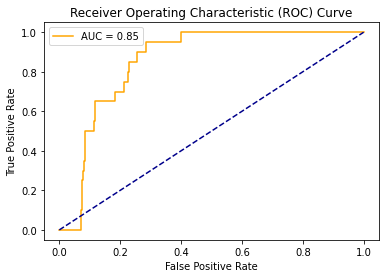

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=50, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'SciForest')